# A discrete Bayesian model for pain level prediction

## Introduction

_motivations and assumptions for using the model_

### _why Bayesian network_
Compared to linear regression and artificial neural network, Bayesian network uses statistical inference to make prediction, which can overcome the difficulty of missing parameters. 

### _relevance to our solution_
There are two steps in this algorithm: 

(1) create the Bayesian network by collecting pain questionnaire answers and sensor data from *communicative* patients;

(2) use the network to infer the level of pains given the biological data, for *non-communicative patients*

Because non-communicative children might not demonstrate behaviors that can be well observed or are not able to self report their pain levels, some parameters are missing. Bayesian network can come in handy.

### _variable choice_
- To show a proof of concept, each variable in this model will be discrete and binary. 
- "True" means "parameter measured falls in normal range"
- "False" means "parameter measured falls in abnormal range"

### _where do we get the probability?_
Probability values used in this example are artificially generated. But we will show how to calculate these probabilities from collected data.

### _future consideration_
- We plan to assign more categories to each variable. By having multiple categories for each variable (for example, social behaviors can be specified as five types: unhappy, withdrawn, seeking closeness, hard to pacify), the model can make more subtle predictions

In [19]:
%pylab inline
from pomegranate import *

Populating the interactive namespace from numpy and matplotlib


## Initialize the root nodes

### _background_
- Root nodes are variables for which we don't care about their probabilities conditioned on anything else. We want to know, given these data from the beginning, what is the final prediction

- In other words, these should be data from the sensor because they can be simply measured and objectively obtained, and we want to infer about the pain level using just these sensor data. 

- For, root nodes of the causal graph, each has a 50/50 chance of being TRUE (normal) or FALSE (false). 

### _what are root nodes in our case?_
- The solution in our device will measure heart rate variability, respiration rate, actigraphy, and skin conductance
- To make each variable binary, we used a unique numerical range to binarize collected data. That is, data points lie inside of the range are considered normal, and those outside considered abnormal

In [23]:
HeartRate_var = DiscreteDistribution( { 'True' : 0.5, 'False' : 0.5 } )

RespRate = DiscreteDistribution( { 'True' : 0.5, 'False' : 0.5 } )

SkinCond = DiscreteDistribution( { 'True' : 0.5, 'False' : 0.5 } )

Actigraphy = DiscreteDistribution( { 'True' : 0.5, 'False' : 0.5 } )


## Conditional dependence (single dependence)


### _background_
- in a causal network, non-root nodes have conditional probability, meaning the probability of them happening is with respect to (conditioned on) their parent nodes 
- some events depend on only one parent node (single dependence)
- more strictly speaking, we put them as non-root because we want to know how these factors play into the final prediction.

### _in our case_
- here we model parameters that can be collected by the phone app as non-root nodes
- recall that our phone allows the third-party to put in their observations of the patients, which includes the 4 parameters: sleeping patterns, eating patterns, social behaviors, and verbal activity.
- All 4 parameters here each can depends on some or all 4 types of sensor data (root nodes in the last section), ideally there will be 4*3 =12 total edges in the graph at max. 
- Here we only show some examples of singular depedence (meaning the node only is conditioned on only one event)


In [24]:

# P (sleeping = normal or abnormal | heart rate variability = normal or abnormal)
sleeping_HR = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.2 ], 
     # given heart rate var is normal, the probability of sleeping is normal
     [ 'True', 'False', 0.8 ],
     # given .... normal, the prob ... abnormal
     [ 'False', 'True', 0.01 ],
     [ 'False', 'False', 0.99 ]], [HeartRate_var])

# P (social behaviors = normal or abnormal | respiration rate)
social_RP = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.2 ], 
     [ 'True', 'False', 0.8 ],
     [ 'False', 'True', 0.44 ],
     [ 'False', 'False', 0.56 ]], [RespRate])



## More conditional dependence 

### _background_
- Sometimes the probability of an event happening can conditionally depend on more than one event. Here we look at parameters that depend on more than one other parameters. 
- The parameters that are collected in the same phase might also depend on each other

### _what are some examples of multiple dependence in our model?_
- eating behaviors depend on both heart rate and skin conductance
- verbal activities depend on respiration rate and  and heart rate
- facial scales depend on verbal activity and actigraphy
- emotional scales depend on eating, sleeping, and actigraphy


In [33]:
# P (eating | respiration rate, skin conductance)
eating_RP_SC =  ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 0.96 ],
     [ 'True', 'True', 'False', 0.04 ],
     [ 'True', 'False', 'True', 0.89 ],
     [ 'True', 'False', 'False', 0.11 ],
     [ 'False', 'True', 'True', 0.96 ],
     [ 'False', 'True', 'False', 0.04 ],
     [ 'False', 'False', 'True', 0.89 ],
     [ 'False', 'False', 'False', 0.11 ]], [RespRate, SkinCond])

verbal_HR_RP =  ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 0.96 ],
     [ 'True', 'True', 'False', 0.04 ],
     [ 'True', 'False', 'True', 0.89 ],
     [ 'True', 'False', 'False', 0.11 ],
     [ 'False', 'True', 'True', 0.96 ],
     [ 'False', 'True', 'False', 0.04 ],
     [ 'False', 'False', 'True', 0.89 ],
     [ 'False', 'False', 'False', 0.11 ]], [HeartRate_var, RespRate])

facial_verbal_SC =  ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 0.46 ],
     [ 'True', 'True', 'False', 0.54 ],
     [ 'True', 'False', 'True', 0.39 ],
     [ 'True', 'False', 'False', 0.61 ],
     [ 'False', 'True', 'True', 0.96 ],
     [ 'False', 'True', 'False', 0.04 ],
     [ 'False', 'False', 'True', 0.03 ],
     [ 'False', 'False', 'False', 0.97 ]], [verbal_HR_RP, Actigraphy])

emotional_eat_sleep_ag =  ConditionalProbabilityTable(
    [[ 'True', 'True', 'True','True', 0.44 ],
     [ 'True', 'True', 'True','False', 0.56 ],
     [ 'True', 'True', 'False','True', 0.90 ],
     [ 'True', 'True', 'False','False', 0.10 ],
     [ 'True', 'False', 'True','True', 0.38],
     [ 'True', 'False', 'True','False', 0.62 ],
     [ 'True', 'False', 'False','True', 0.29 ],
     [ 'True', 'False', 'False','False', 0.71 ],
     [ 'False', 'True', 'True','True', 0.96 ],
     [ 'False', 'True', 'True','False', 0.04 ],
     [ 'False', 'True', 'False','True', 0.52 ],
     [ 'False', 'True', 'False','False', 0.48 ],
     [ 'False', 'False', 'True','True', 0.77 ],
     [ 'False', 'False', 'True','False', 0.23 ],
     [ 'False', 'False', 'False','True', 0.19 ],
     [ 'False', 'False', 'False','False', 0.81 ]],[eating_RP_SC, sleeping_HR, Actigraphy])



## Last layer (leaf nodes)

Now we construct the leaf nodes which are the end of this network. Since we would like to know the probability of pain or not pain given all parameters provided above, we will set pain level as the child of facial and emotional scale and verbal activity

In [34]:
pain_facial_emo_verbal = ConditionalProbabilityTable(
    [[ 'True', 'True', 'True','True', 0.44 ],
     [ 'True', 'True', 'True','False', 0.56 ],
     [ 'True', 'True', 'False','True', 0.90 ],
     [ 'True', 'True', 'False','False', 0.10 ],
     [ 'True', 'False', 'True','True', 0.88],
     [ 'True', 'False', 'True','False', 0.12 ],
     [ 'True', 'False', 'False','True', 0.29 ],
     [ 'True', 'False', 'False','False', 0.71 ],
     [ 'False', 'True', 'True','True', 0.76 ],
     [ 'False', 'True', 'True','False', 0.24 ],
     [ 'False', 'True', 'False','True', 0.52 ],
     [ 'False', 'True', 'False','False', 0.48 ],
     [ 'False', 'False', 'True','True', 0.77 ],
     [ 'False', 'False', 'True','False', 0.23 ],
     [ 'False', 'False', 'False','True', 0.19 ],
     [ 'False', 'False', 'False','False', 0.81 ]],[emotional_eat_sleep_ag, facial_verbal_SC, verbal_HR_RP])



## Create and plot the network
After we defined all events and their conditional probabilities, we can construct and plot our network!!


In [46]:
s0 = State( HeartRate_var, name="Heart Rate Variability" )
s1 = State( RespRate, name="Respiration Rate" )
s2 = State( SkinCond, name="Skin Conductance" )
s3 = State( Actigraphy, name="Actigraphy" )
s4 = State( sleeping_HR, name="Sleeping Behaviors" )
s5 = State( social_RP, name="Social Behaviors" )
s6 = State( eating_RP_SC, name="Eating Behaviors")
s7 = State( verbal_HR_RP, name="Verbal Activities" )
s8 = State( facial_verbal_SC, name='Facial Scale' )
s9 = State( emotional_eat_sleep_ag,name="Emotional Scale")
s10 = State( pain_facial_emo_verbal,name="Pain Level")


In [36]:
network = BayesianNetwork( "Pain-Track" )
network.add_nodes(s0, s1, s2, s3, s4, s5, s6, s7,s8,s9,s10)

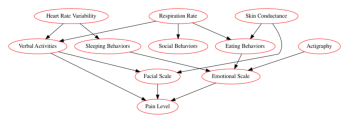

In [39]:
network.add_edge( s0, s4 )
network.add_edge( s1, s5 )
network.add_edge( s1, s6 )
network.add_edge( s2, s6 )
network.add_edge( s0, s7 )
network.add_edge( s1, s7 )
network.add_edge( s2, s8 )
network.add_edge( s7, s8 )
network.add_edge( s4, s9 )
network.add_edge( s6, s9 )
network.add_edge( s3, s9 )
network.add_edge( s8, s10 )
network.add_edge( s9, s10 )
network.add_edge( s7, s10)

try:
    import tempfile
    import pygraphviz
    import matplotlib.pyplot as plt
    import matplotlib.image
except ImportError:
    pygraphviz = None
    
network.bake()
network.plot()

## Make Inference using our constructed model!
Now given the network constructed above, let's test if a person who has normal skin conductance, normal facial scale, and abnormal sleeping behaviors is likely to experience pain


In [59]:
observations = { 'verbal_HR_RP' : 'False', 'facial_verbal_SC' : 'True', 'HeartRate_var' : 'True' }
network.predict_proba(observations)
#beliefs = map( str, network.predict_proba( observations ) )
#print("\n".join( "{}\t\t{}".format( state.name, belief ) for state, belief in zip( network.states, beliefs ) ))

ValueError: None is not in list